In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l_n1gj1f
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-l_n1gj1f


In [2]:
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm

from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import random

import os

cuda = torch.cuda.is_available()
print("cuda", cuda)
num_workers = 8 if cuda else 0
print(num_workers)
print("Torch version:", torch.__version__)
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import numpy as np
import torch
from tqdm.notebook import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from torch import nn
from torch.nn.utils.rnn import *
import fnmatch
import clip

cuda True
8
Torch version: 1.7.1


In [3]:
print("Avaliable Models: ", clip.available_models())
model, preprocess = clip.load("RN50") # clip.load("ViT-B/32") #

input_resolution = model.input_resolution #.item()
context_length = model.context_length #.item()
vocab_size = model.vocab_size #.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Avaliable Models:  ['RN50', 'RN101', 'RN50x4', 'ViT-B/32']
Model parameters: 102,007,137
Input resolution: tensor(224, device='cuda:0')
Context length: tensor(77, device='cuda:0')
Vocab size: tensor(49408, device='cuda:0')


In [4]:
templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

In [5]:
labels = os.listdir('/home/ubuntu/validation/')
labels

['swinging_on_something',
 'abseiling',
 '.ipynb_checkpoints',
 'scrambling_eggs',
 'shaking_head',
 'bobsledding',
 'laying_bricks',
 'skiing_slalom',
 'making_tea',
 'washing_hands',
 'high_kick',
 'push_up',
 'bee_keeping']

In [6]:
act_map = {}
for i,v in enumerate(labels):
    act_map[i] = v

In [7]:
act_map

{0: 'swinging_on_something',
 1: 'abseiling',
 2: '.ipynb_checkpoints',
 3: 'scrambling_eggs',
 4: 'shaking_head',
 5: 'bobsledding',
 6: 'laying_bricks',
 7: 'skiing_slalom',
 8: 'making_tea',
 9: 'washing_hands',
 10: 'high_kick',
 11: 'push_up',
 12: 'bee_keeping'}

In [8]:
classnames = labels

In [9]:
map_id = {}
i=0
for label in classnames:
  map_id[label]=i
  i+=1

In [10]:
classnames_str = {x:x.replace('_', ' ') for x in classnames}
classnames_str

{'swinging_on_something': 'swinging on something',
 'abseiling': 'abseiling',
 '.ipynb_checkpoints': '.ipynb checkpoints',
 'scrambling_eggs': 'scrambling eggs',
 'shaking_head': 'shaking head',
 'bobsledding': 'bobsledding',
 'laying_bricks': 'laying bricks',
 'skiing_slalom': 'skiing slalom',
 'making_tea': 'making tea',
 'washing_hands': 'washing hands',
 'high_kick': 'high kick',
 'push_up': 'push up',
 'bee_keeping': 'bee keeping'}

In [11]:
inv_act_map = {val:key for key, val in act_map.items()}
inv_act_map

{'swinging_on_something': 0,
 'abseiling': 1,
 '.ipynb_checkpoints': 2,
 'scrambling_eggs': 3,
 'shaking_head': 4,
 'bobsledding': 5,
 'laying_bricks': 6,
 'skiing_slalom': 7,
 'making_tea': 8,
 'washing_hands': 9,
 'high_kick': 10,
 'push_up': 11,
 'bee_keeping': 12}

In [12]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fbb5c13c730>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [13]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.26862954, 1/0.26130258, 1/0.27577711]),
                                transforms.Normalize(mean = [ -0.48145466, -0.4578275, -0.40821073 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [14]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

In [15]:
import pdb
def zeroshot_classifier(classnames, act_descriptions):
  with torch.no_grad():
    zeroshot_weights = []
    for classname in classnames:
      # texts =  [ act_descriptions[classname][x : x+100] for x in range(0, des_size, 100)]#format with clas
      # pdb.set_trace()
      texts = [template.format(classname) for template in templates]
      texts = clip.tokenize(texts).cuda() #tokenize
      print("shape of texts",texts.shape)
      class_embeddings = model.encode_text(texts) #embed with text encoder
      class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
      class_embedding = class_embeddings.mean(dim=0)
      class_embedding /= class_embedding.norm()
      zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
  return zeroshot_weights


In [16]:
zeroshot_weights = zeroshot_classifier(classnames, classnames_str)

shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])
shape of texts torch.Size([80, 77])


In [18]:
import os
from PIL import Image
ROOT = "/home/ubuntu/validation/"

img_full = []
pred_list = []
target_list = []
probs_full = [] 
for src_dir in os.listdir(ROOT):
    if src_dir == ".ipynb_checkpoints":
        continue
    src_dir_ = os.path.join(ROOT,src_dir)
    for i in range(20):
        vid_dir = os.path.join(src_dir_, str(i+1))
        mid_frame = len(os.listdir(vid_dir))//2
        filename = os.listdir(vid_dir)[mid_frame]
        file_path = os.path.join(vid_dir,filename) 
#         print(file_path)
        img = Image.open(file_path)
        images = preprocess(img)
        img_full.append(images)
        images = torch.unsqueeze(images, 0)
        temp = np.zeros((1,13))
        idx = list(act_map.values()).index(src_dir)
#         print(idx)
        temp[:, idx] = 1
        target = torch.Tensor(temp)
        images = images.cuda()
        target = target.cuda()
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ zeroshot_weights
        probs = logits.softmax(dim=-1)
        probs = probs.type(torch.DoubleTensor)
        probs_full.append(probs[0].detach().cpu().numpy())
        top1 = np.argmax(probs.detach().cpu().numpy())
#         print("top1",top1)
        pred_list.append(top1)
        target_list.append(idx)


In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_list, target_list)

0.6416666666666667

In [20]:
import warnings
warnings.filterwarnings(action='ignore')

In [21]:
import logging

logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

In [24]:
warnings.filterwarnings(action='ignore')
probs_full_arr = np.array(probs_full)
# print(probs_full_arr.shape)
top_10_incides = {}
for i in range(0, 13):
	top_10_incides[i] = probs_full_arr[:, i].argsort()[-10:][::-1]
top_10_incides

{0: array([  2,  18,  15,  12,   4,   7,   9, 204,   1,  61]),
 1: array([31, 39, 20, 34, 21, 11, 37, 36, 19, 38]),
 2: array([162,  52, 101,  79,  69, 165, 186,  93, 166,  75]),
 3: array([56, 47, 41, 58, 57, 44, 59, 51, 48, 46]),
 4: array([ 79, 165,  88, 198,  71,  62,  74,  77, 239,  68]),
 5: array([92, 86, 96, 97, 89, 87, 91, 85, 99, 95]),
 6: array([100, 115, 117, 109, 114, 118, 116, 102, 225, 110]),
 7: array([138, 127, 123, 122, 139, 135, 132, 124, 126, 125]),
 8: array([145, 143, 150, 152,  55, 155,  40,  53, 140, 159]),
 9: array([172, 175, 160, 161, 174, 164, 176, 163, 171, 173]),
 10: array([196, 192, 194, 185, 199, 180, 193,   5, 184, 203]),
 11: array([215, 202, 206, 205, 219, 201, 200,  70, 217, 170]),
 12: array([238, 230, 232, 222, 235, 220, 237, 229, 224, 228])}

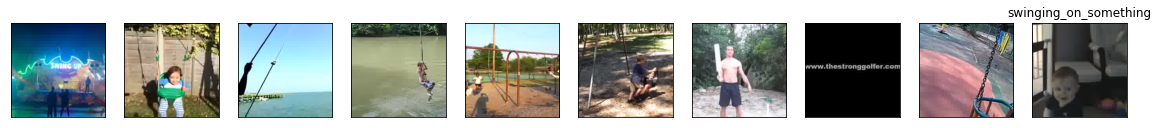

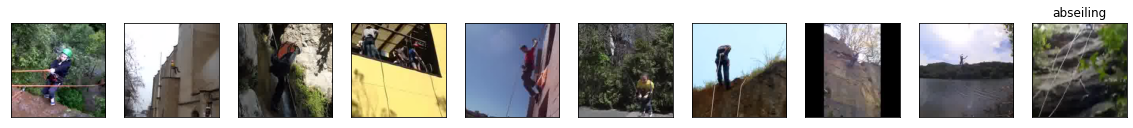

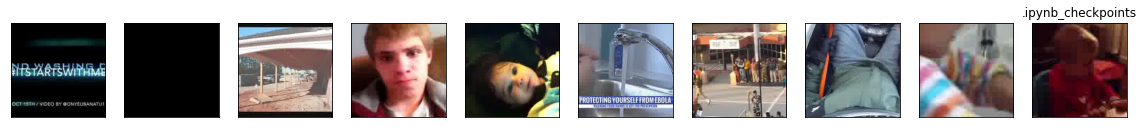

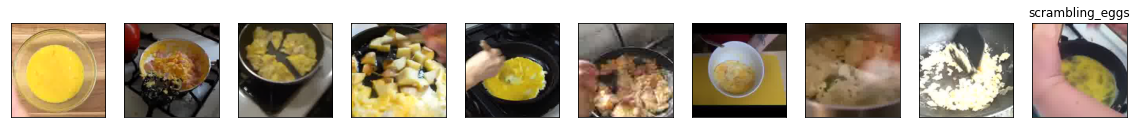

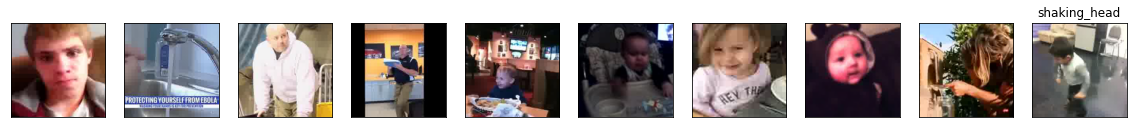

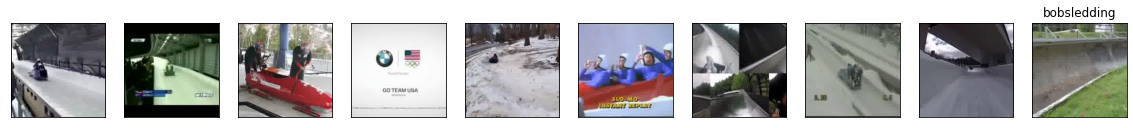

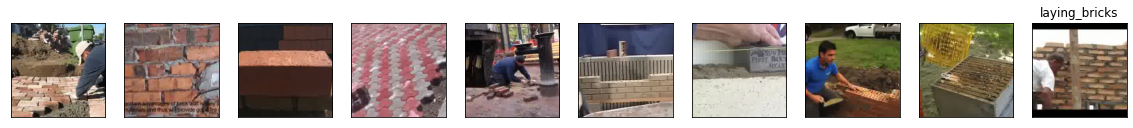

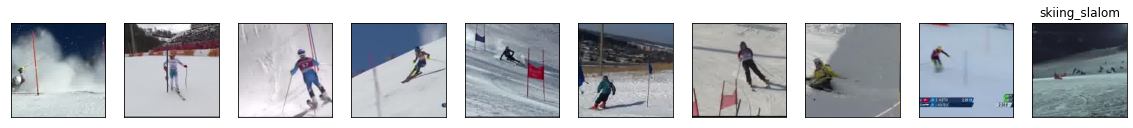

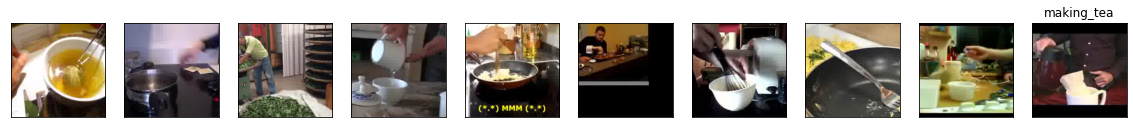

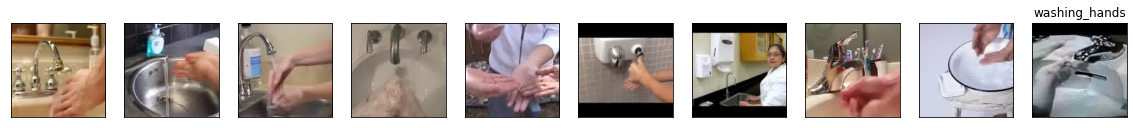

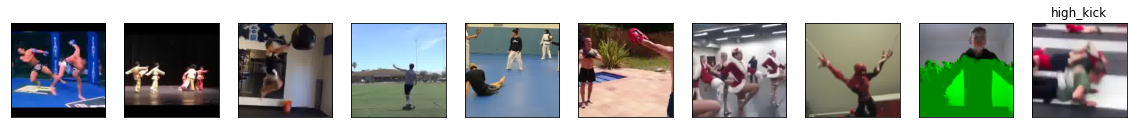

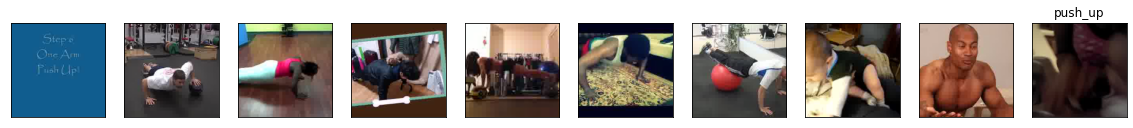

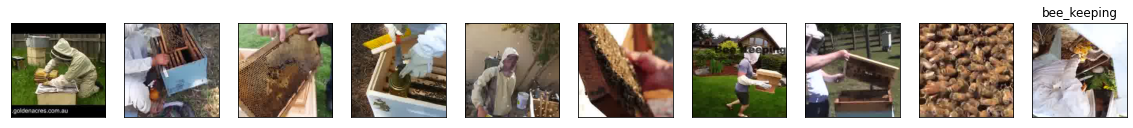

In [25]:
for i in range(0, 13):
	fig = plt.figure(figsize=(20, 5))
	for j in range(10):
		plt.subplot(1, 10, j + 1)
		k = top_10_incides[i][j]
		inv_tensor = invTrans(img_full[k])
		plt.imshow(inv_tensor.cpu().numpy().transpose(1,2,0))
		ax = plt.gca()
		ax.axes.xaxis.set_visible(False)
		ax.axes.yaxis.set_visible(False)
	plt.title(classnames[i])

	plt.show()